<a href="https://colab.research.google.com/github/abcardoso/ifes_ann/blob/main/202401_ANN_Note03_forecasting_AnaB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
pip install requests


## Base de dados escolhida

Os dados do IPCA  (Índice Nacional de Preços ao Consumidor Amplo) representam a inflação mensal acumulada no Brasil, coletados e disponibilizados pela API do Banco Central do Brasil. Esses dados foram escolhidos para forecasting devido à sua importância econômica e características intrínsecas de séries temporais, como tendências e sazonalidade.

In [20]:
import requests
import json

# URL dos dados do IPCA em formato JSON
url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.10841/dados?formato=json'

response = requests.get(url)

# Verificar se a solicitação foi bem-sucedida
if response.status_code == 200:
    ipca_json_data = response.json()
    # Imprimir os primeiros 5 elementos para teste
    print(ipca_json_data[:5])
else:
    print("Falha na solicitação: Status", response.status_code)



[{'data': '01/01/1992', 'valor': '28.12'}, {'data': '01/02/1992', 'valor': '25.28'}, {'data': '01/03/1992', 'valor': '22.16'}, {'data': '01/04/1992', 'valor': '20.43'}, {'data': '01/05/1992', 'valor': '26.10'}]


## Definições

O window_size de 12 foi escolhido para a criação das sequências usadas no modelo Dense. Este tamanho de janela significa que estamos usando dados dos 12 meses anteriores para prever o valor do próximo mês. Este parâmetro foi escolhido considerando a sazonalidade anual típica em dados econômicos, permitindo que o modelo capture padrões anuais na inflação.

In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Converter JSON em lista de valores (float)
data_values = [float(item['valor']) for item in ipca_json_data]

# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
data_values_scaled = scaler.fit_transform(np.array(data_values).reshape(-1, 1))

# Função para criar sequências de dados (X, y)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        seq_x, seq_y = data[i:(i + window_size)], data[i + window_size]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Definir tamanho da janela
window_size = 12

# Criar sequências
X, y = create_sequences(data_values_scaled, window_size)


#Baseline

In [22]:
import numpy as np
from sklearn.metrics import mean_absolute_error

mean = np.mean(data_values_scaled)
std = np.std(data_values_scaled)

def evaluate_naive_method(X, y):
    total_abs_err = 0.
    samples_seen = 0
    for i in range(len(X)):
        # Usando o último valor da sequência como a previsão
        preds = X[i, -1, 0] * std + mean  # Adapte o índice se necessário
        actual = y[i] * std + mean
        total_abs_err += np.abs(preds - actual)
        samples_seen += 1
    return total_abs_err / samples_seen

# Calcular o erro absoluto médio para o modelo Naïve
naive_error = evaluate_naive_method(X, y)
print(f'Mean Absolute Error for Naive Forecast: {naive_error}')


Mean Absolute Error for Naive Forecast: [0.00243555]


#Densely Conected

In [25]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import numpy as np

from sklearn.model_selection import train_test_split

# Normalização dos dados
scaler = MinMaxScaler()
data_values_scaled = scaler.fit_transform(np.array(data_values).reshape(-1, 1))

# Criar sequências como anteriormente
X, y = create_sequences(data_values_scaled, window_size)

# Dividir os dados em treinamento e teste
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir os dados temporários em validação e teste
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reformatar X para 2D para modelos densamente conectados
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_val_flat = X_val.reshape((X_val.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

# Construir e treinar o modelo
inputs = keras.Input(shape=(X_train_flat.shape[1],))
x = layers.Dense(16, activation="relu")(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=['mae'])

# Configuração do checkpoint
callbacks = [
    keras.callbacks.ModelCheckpoint("model.keras", save_best_only=True)
]

history = model.fit(X_train_flat, y_train, epochs=10, validation_data=(X_val_flat, y_val), callbacks=callbacks)

# Carregar o melhor modelo salvo
model = keras.models.load_model("model.keras")

# Avaliar o modelo no conjunto de teste
test_mae = model.evaluate(X_test_flat, y_test)[1]
print(f"Test MAE: {test_mae:.2f}")


Epoch 1/10
10/10 [==============================] - 1s 20ms/step - loss: 0.0709 - mae: 0.0973 - val_loss: 0.1254 - val_mae: 0.1450
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0467 - mae: 0.0660 - val_loss: 0.0907 - val_mae: 0.1272
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0330 - mae: 0.0638 - val_loss: 0.0607 - val_mae: 0.1190
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0226 - mae: 0.0655 - val_loss: 0.0398 - val_mae: 0.1059
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0155 - mae: 0.0621 - val_loss: 0.0292 - val_mae: 0.0890
Epoch 6/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0116 - mae: 0.0522 - val_loss: 0.0187 - val_mae: 0.0734
Epoch 7/10
10/10 [==============================] - 0s 7ms/step - loss: 0.0082 - mae: 0.0426 - val_loss: 0.0106 - val_mae: 0.0604
Epoch 8/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0062 - mae: 0.0

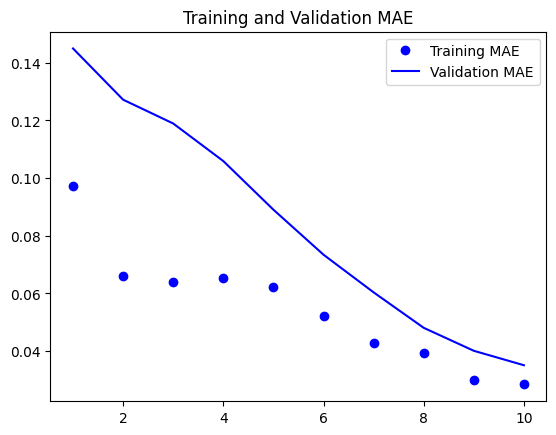

In [26]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()